In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.preprocessing import LabelEncoder, scale,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
import joblib
import sklearn

In [3]:
print(tf.__version__)

2.15.0


# Functions

# plot column distribution and outliers

In [4]:
def plot_column_visualizations(data, column_name):
    # Box and whisker plot
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 3, 1)
    sns.boxplot(y=data[column_name])
    plt.title('Box and Whisker Plot')

    # Scatter plot
    plt.subplot(2, 3, 2)
    sns.scatterplot(data=data, x=column_name, y="class")
    plt.title('Scatter Plot')

    # Histogram
    plt.subplot(2, 3, 3)
    plt.hist(data[column_name])
    plt.title('Histogram')

    # Distribution plot
    plt.subplot(2, 3, 4)
    sns.kdeplot(data[column_name], fill=True)
    plt.title('Distribution Plot')

    # QQ plot
    plt.subplot(2, 3, 5)
    stats.probplot(data[column_name], dist="norm", plot=plt)
    plt.title('QQ Plot')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


# Detecting Outliers

In [5]:

def detect_outliers(data, column_name):
    # Perform a hypothesis test for normality (Shapiro-Wilk test)
    shapiro_p_value = stats.shapiro(data[column_name])[1]
    is_normal = shapiro_p_value > 0.05  # Check if the data is normally distributed

    # Z-score method
    z_scores = (data[column_name] - data[column_name].mean()) / data[column_name].std()
    z_outliers = data[abs(z_scores) > 3]

    # Print the results
    print("_" * 50, "\n")
    print("Hypothesis Testing (Shapiro-Wilk test):")
    print("Is the data normally distributed?", is_normal)
    print("Shapiro-Wilk p-value:", shapiro_p_value,"\n")

    return z_outliers[[column_name]]


# Plot Confusion matrix

In [6]:
def conv_mat(y_test,predictions):
  cm = confusion_matrix(y_test, predictions)
  # Display confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

# Remove outliers

In [7]:

def remove_outliers( df , outliers_indices ):
  df = df.drop(outliers_indices.index)
  return df


# Log transformation

In [8]:
def log_transform(df,col_name):
  col_transformed = np.log(df[col_name])
  return  col_transformed

# Target encoding


In [9]:
def target_encode(df,col_name):
   encoded_col = LabelEncoder().fit_transform(df[col_name])
   return encoded_col

# Data scaling

In [10]:
scaler = StandardScaler()
def scaling(df):
    scaled_df = scaler.fit_transform(df)
    return scaled_df

# Loading Data

## About Dataset
Cardiovascular illnesses (CVDs) are the major cause of death worldwide. CVDs include coronary heart disease, cerebrovascular disease, rheumatic heart disease, and other heart and blood vessel problems. According to the World Health Organization, 17.9 million people die each year. Heart attacks and strokes account for more than four out of every five CVD deaths, with one-third of these deaths occurring before the age of 70. A comprehensive database for factors that contribute to a heart attack has been constructed.

The main purpose here is to collect characteristics of Heart Attack or factors that contribute to it.
The size of the dataset is 1319 samples, which have nine fields, where eight fields are for input fields and one field for an output field. Age, gender(0 for Female, 1 for Male) ,heart rate (impulse), systolic BP (pressurehight), diastolic BP (pressurelow), blood sugar(glucose), CK-MB (kcm), and Test-Troponin (troponin) are representing the input fields, while the output field pertains to the presence of heart attack (class), which is divided into two categories (negative and positive); negative refers to the absence of a heart attack, while positive refers to the presence of a heart attack.

In [11]:
data = pd.read_csv("/content/drive/MyDrive/datasets/Heart_Attack.csv")

In [12]:
df = pd.DataFrame(data)

In [13]:
df.head(-5)

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative
...,...,...,...,...,...,...,...,...,...
1309,47,1,94,105,81,135.0,36.24,0.263,positive
1310,70,0,80,135,75,351.0,2.21,10.000,positive
1311,85,1,112,115,69,114.0,2.19,0.062,positive
1312,48,1,84,118,68,96.0,5.33,0.006,negative


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1319 non-null   int64  
 1   gender         1319 non-null   int64  
 2   impluse        1319 non-null   int64  
 3   pressurehight  1319 non-null   int64  
 4   pressurelow    1319 non-null   int64  
 5   glucose        1319 non-null   float64
 6   kcm            1319 non-null   float64
 7   troponin       1319 non-null   float64
 8   class          1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [15]:
df.describe()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


# Data Distribution

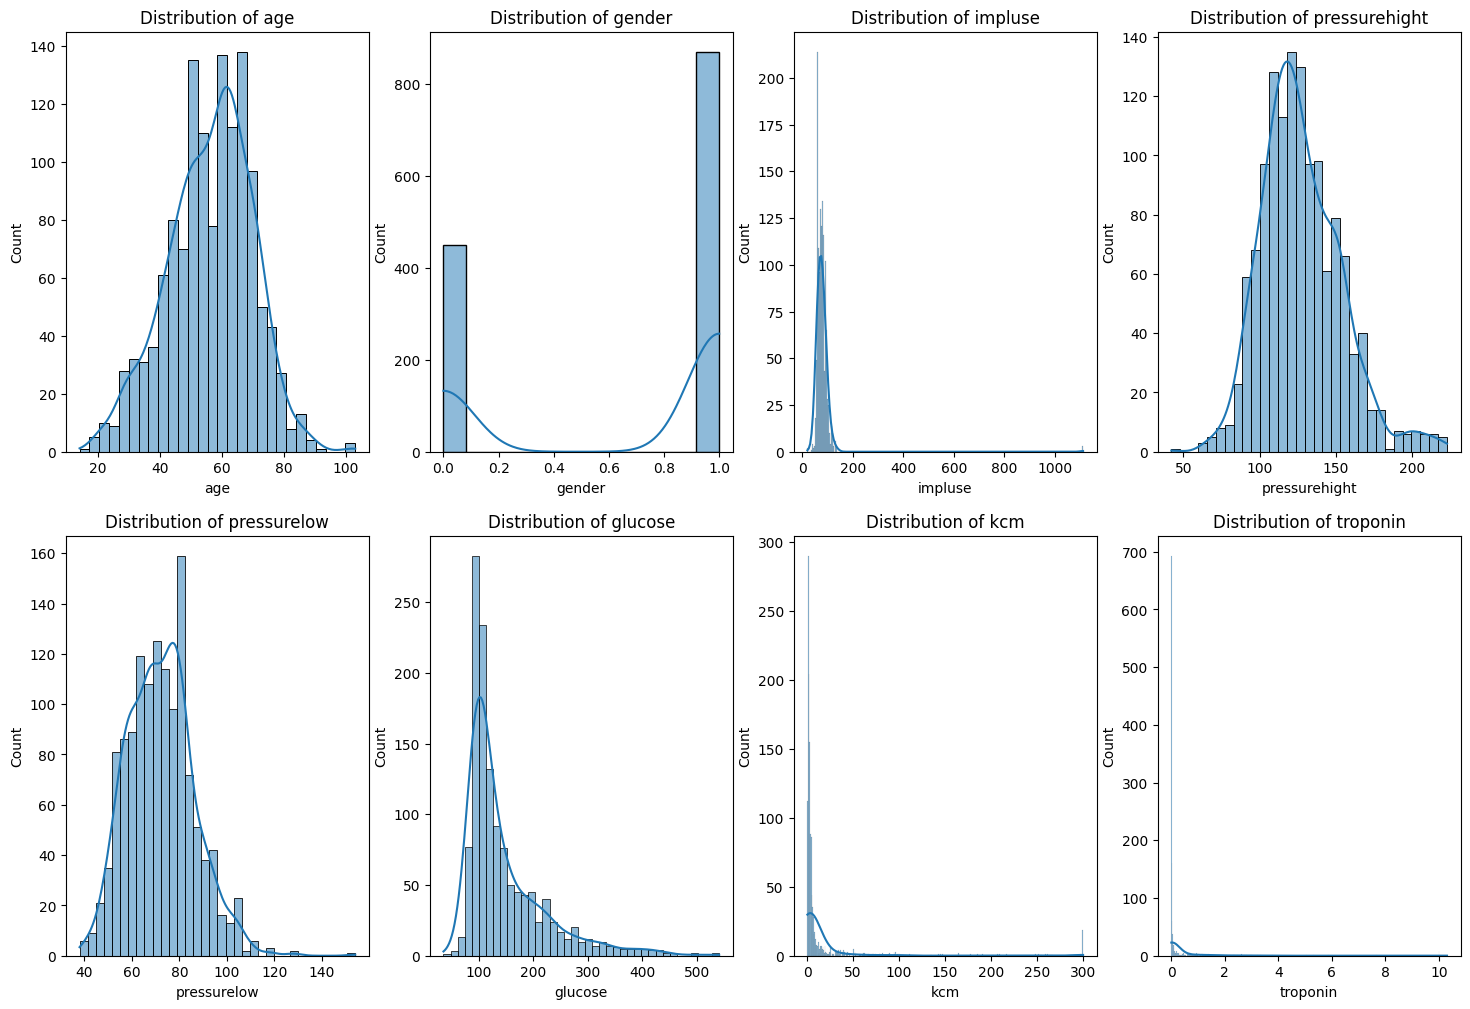

In [16]:
cols = df.drop('class',axis=1)
plt.figure(figsize=(18, 12))
for i, column in enumerate(cols.columns):
    plt.subplot(2, 4, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')

# Show Skeweness

In [17]:
cols = df.drop('class',axis=1)
for column in cols.columns:
    sek = df[column].skew()
    if(sek < 0) :
        sek = -sek
    print(f"column  {column} : " , sek)
    if sek == 0:
        print ('Normal')
    elif -0.5 <= sek <= 0.5:
        print('Approximately Symmetric')
    elif sek >= 1 or sek <= 1:
        print('Skewed')

column  age :  0.23921873824246861
Approximately Symmetric
column  gender :  0.6743628337800194
Skewed
column  impluse :  18.24771989662879
Skewed
column  pressurehight :  0.6852460958110306
Skewed
column  pressurelow :  0.48920228416877803
Approximately Symmetric
column  glucose :  1.933474909905609
Skewed
column  kcm :  4.978095271058858
Skewed
column  troponin :  5.799106921990377
Skewed


# Detect null vlues

In [18]:
df.isna().sum() # data clear from null values

age              0
gender           0
impluse          0
pressurehight    0
pressurelow      0
glucose          0
kcm              0
troponin         0
class            0
dtype: int64

# Detecting Outliers

## Age

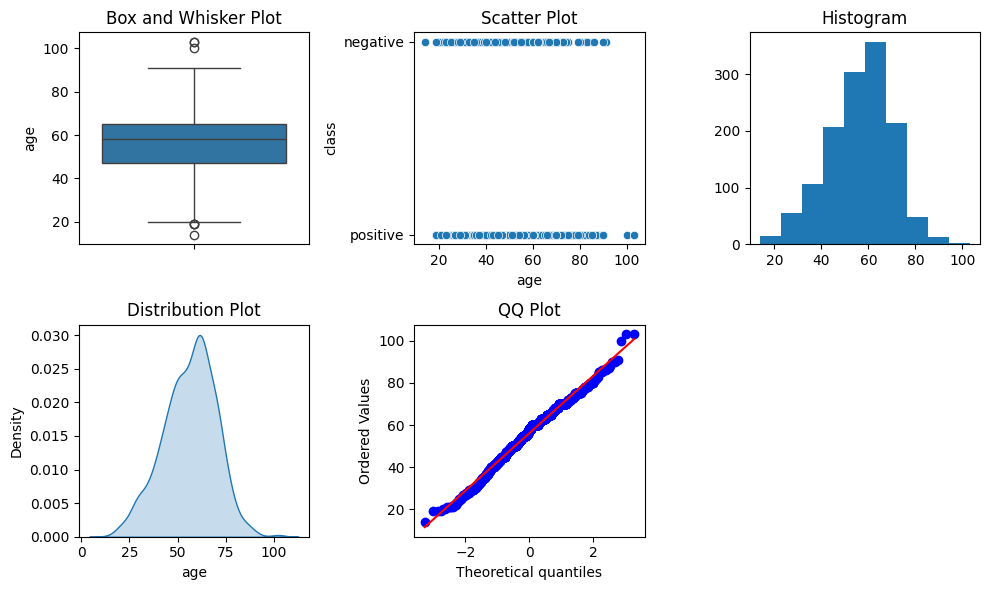


age description


count    1319.000000
mean       56.191812
std        13.647315
min        14.000000
25%        47.000000
50%        58.000000
75%        65.000000
max       103.000000
Name: age, dtype: float64

In [19]:
plot_column_visualizations(df, 'age')
print(f'\nage description')
df["age"].describe()

## gender

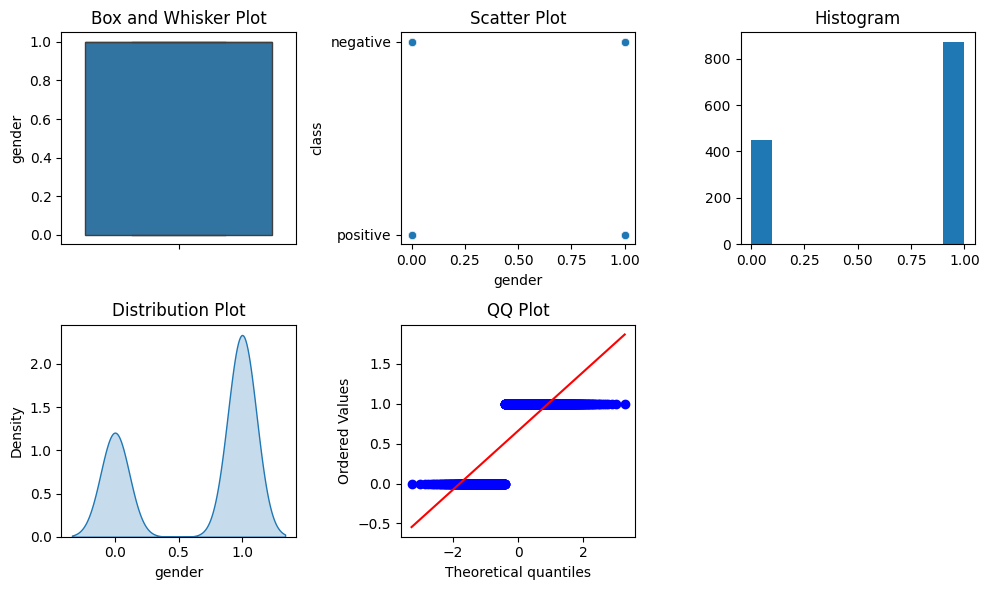


gender description


count    1319.000000
mean        0.659591
std         0.474027
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

In [20]:
plot_column_visualizations(df, 'gender')
print(f'\ngender description')
df["gender"].describe()

## impluse

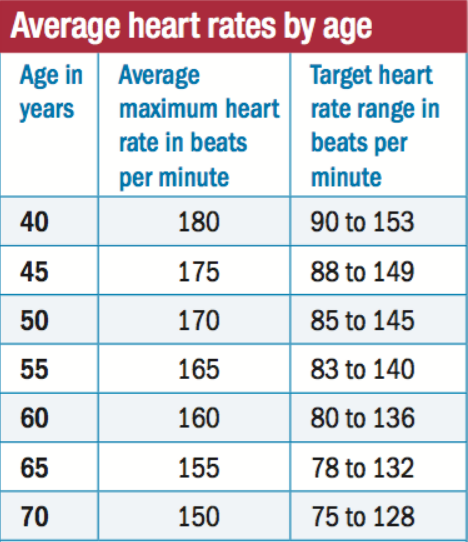

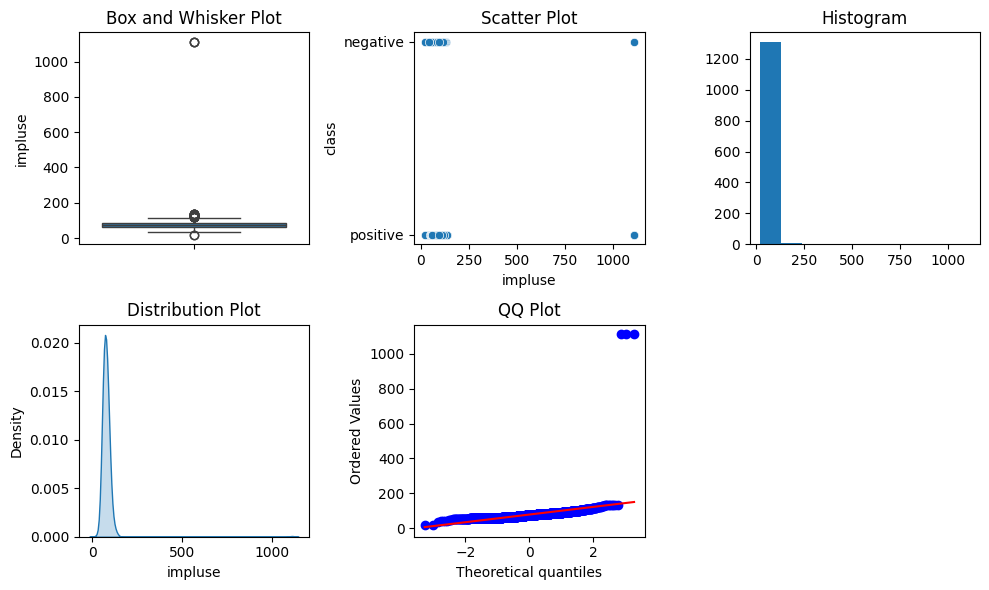

__________________________________________________ 

Hypothesis Testing (Shapiro-Wilk test):
Is the data normally distributed? False
Shapiro-Wilk p-value: 0.0 


impluse description
count    1319.000000
mean       78.336619
std        51.630270
min        20.000000
25%        64.000000
50%        74.000000
75%        85.000000
max      1111.000000
Name: impluse, dtype: float64


,impluse
63,1111
717,1111
1069,1111


In [21]:
plot_column_visualizations(df, 'impluse')
impulse_out = detect_outliers(df, 'impluse')
print(f'\nimpluse description')
print(df["impluse"].describe())
impulse_out

# Remove outliers

In [22]:
df_2 = remove_outliers(df,impulse_out)

# impulse after removing outliers

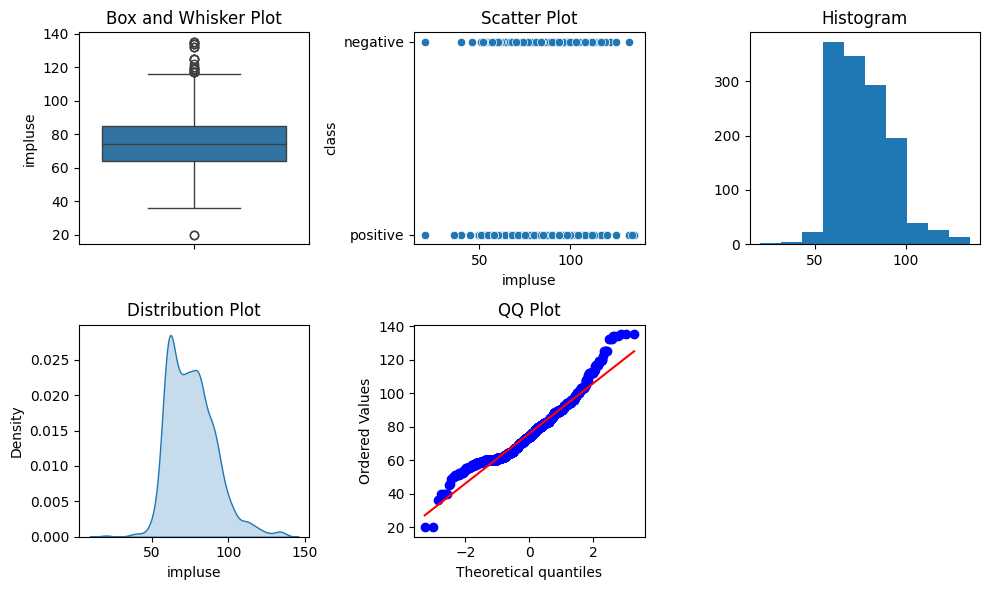


impluse description


count    1316.000000
mean       75.982523
std        15.276877
min        20.000000
25%        64.000000
50%        74.000000
75%        85.000000
max       135.000000
Name: impluse, dtype: float64

In [23]:
plot_column_visualizations(df_2, 'impluse')
print(f'\nimpluse description')
df_2["impluse"].describe()

## pressure hight

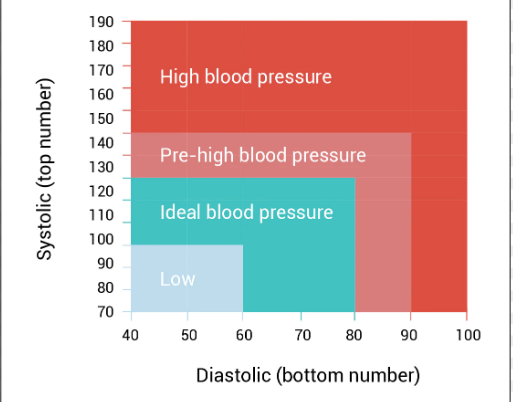

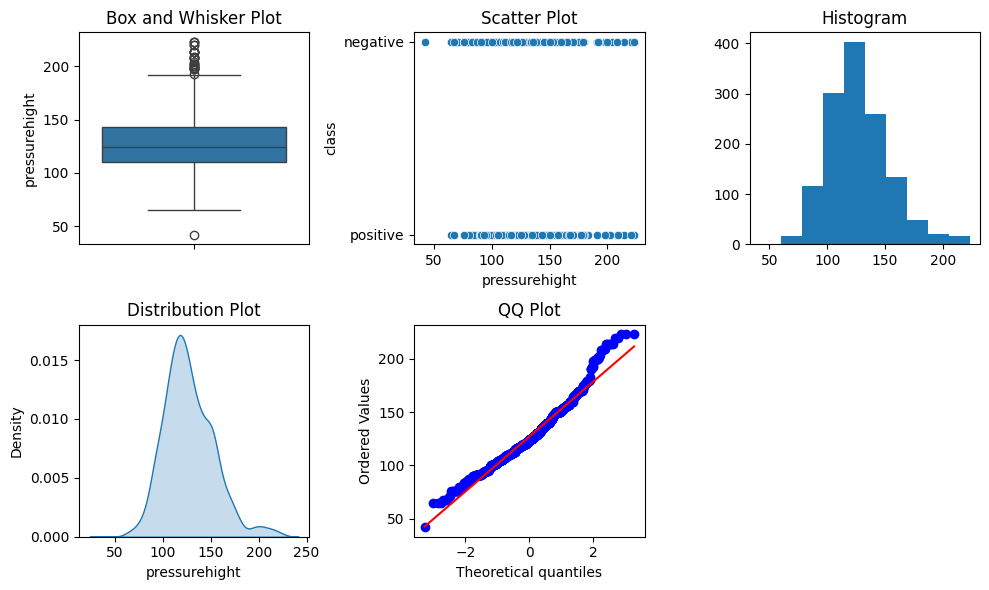


pressurehight description


count    1316.000000
mean      127.139058
std        26.144139
min        42.000000
25%       110.000000
50%       124.000000
75%       143.000000
max       223.000000
Name: pressurehight, dtype: float64

In [24]:
plot_column_visualizations(df_2, 'pressurehight')
print(f'\npressurehight description')
df_2["pressurehight"].describe()

# Pressure Low

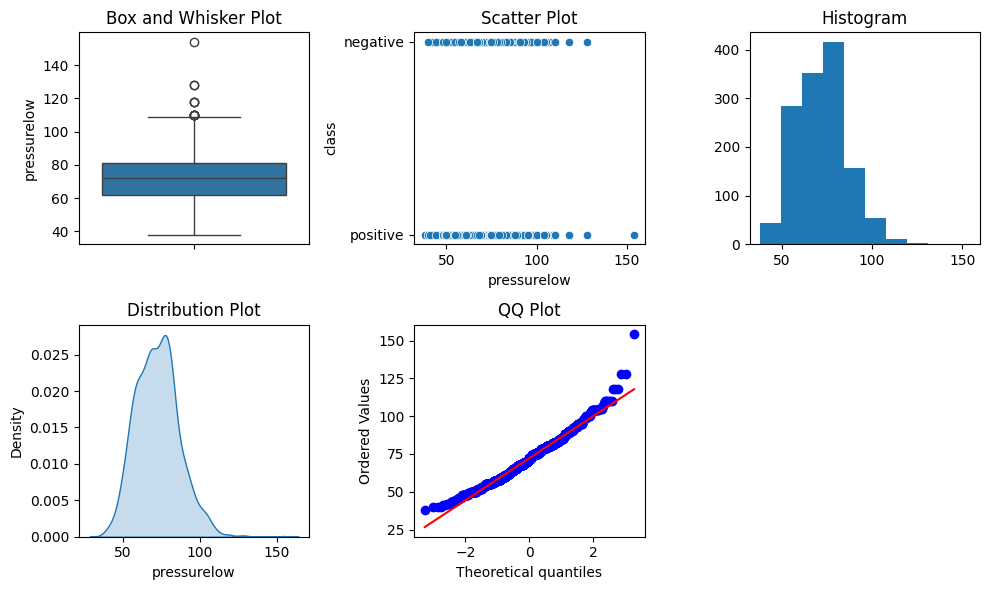


pressurelow description


count    1316.000000
mean       72.217325
std        14.007815
min        38.000000
25%        62.000000
50%        72.000000
75%        81.000000
max       154.000000
Name: pressurelow, dtype: float64

In [25]:
plot_column_visualizations(df_2, 'pressurelow')
print(f'\npressurelow description')
df_2["pressurelow"].describe()

## glucose

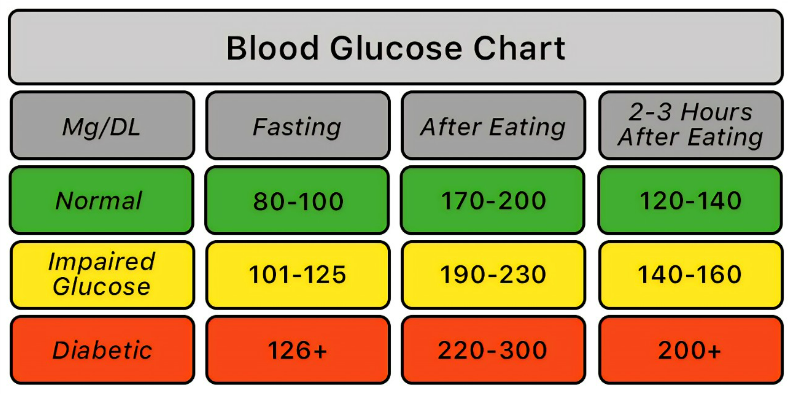

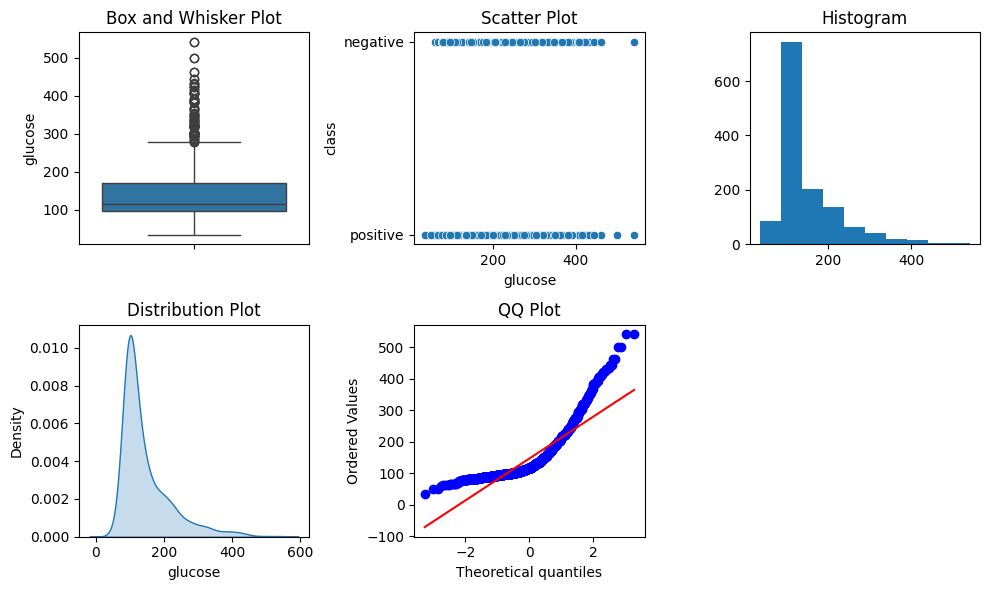


glucose description
count    1316.000000
mean      146.718617
std        74.979672
min        35.000000
25%        98.000000
50%       116.000000
75%       170.000000
max       541.000000
Name: glucose, dtype: float64
__________________________________________________ 

Hypothesis Testing (Shapiro-Wilk test):
Is the data normally distributed? False
Shapiro-Wilk p-value: 1.853391960988072e-38 



,glucose
75,392.0
91,387.0
207,462.0
210,422.0
232,382.0
254,382.0
280,431.0
333,408.0
338,500.0
345,541.0


In [26]:
plot_column_visualizations(df_2, 'glucose')
print(f'\nglucose description')
print(df_2["glucose"].describe())
outliers_glucose = detect_outliers(df_2, 'glucose')
outliers_glucose

# Dropping outliers


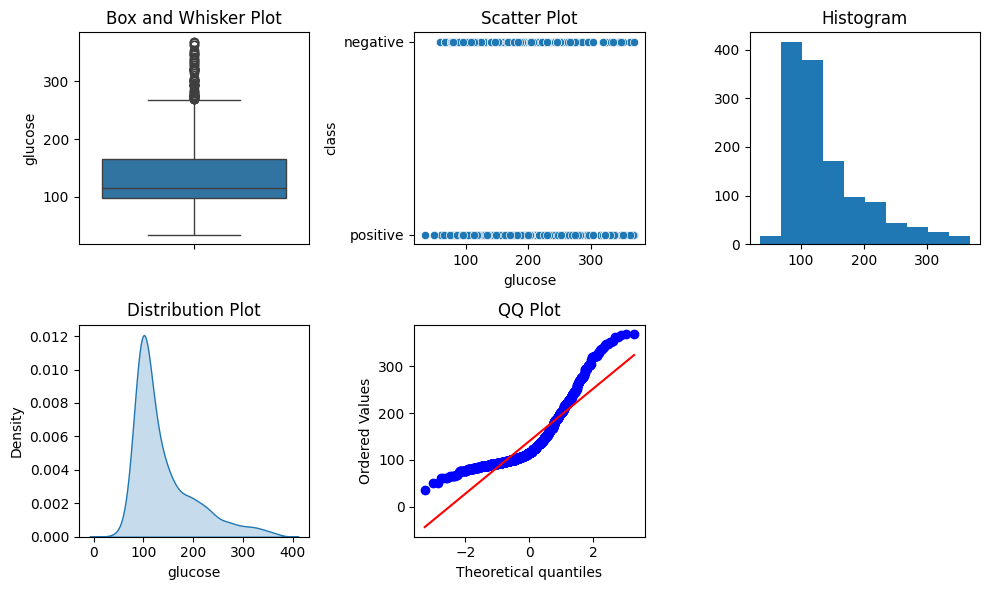

In [27]:
df_2 = remove_outliers(df_2,outliers_glucose)
plot_column_visualizations(df_2, 'glucose')

# Log transformation

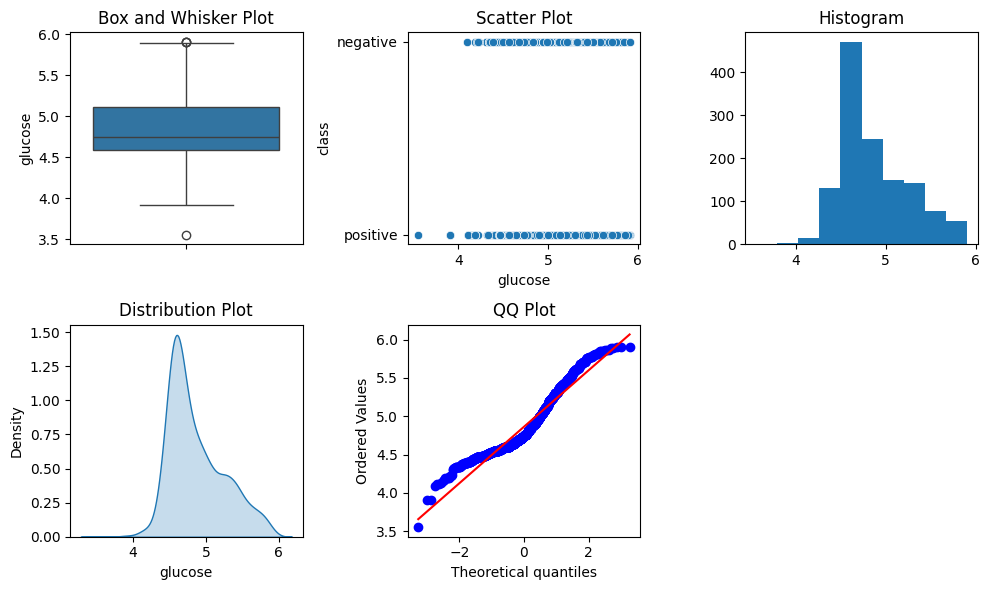


glucose description


count    1285.000000
mean        4.862777
std         0.380718
min         3.555348
25%         4.584967
50%         4.744932
75%         5.111988
max         5.908083
Name: glucose, dtype: float64

In [28]:
df_2.glucose = log_transform(df_2,'glucose')
plot_column_visualizations(df_2, 'glucose')
print(f'\nglucose description')
df_2["glucose"].describe()

## KCM

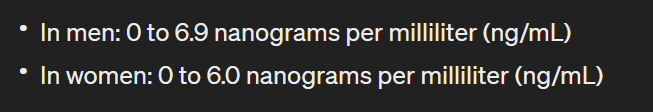

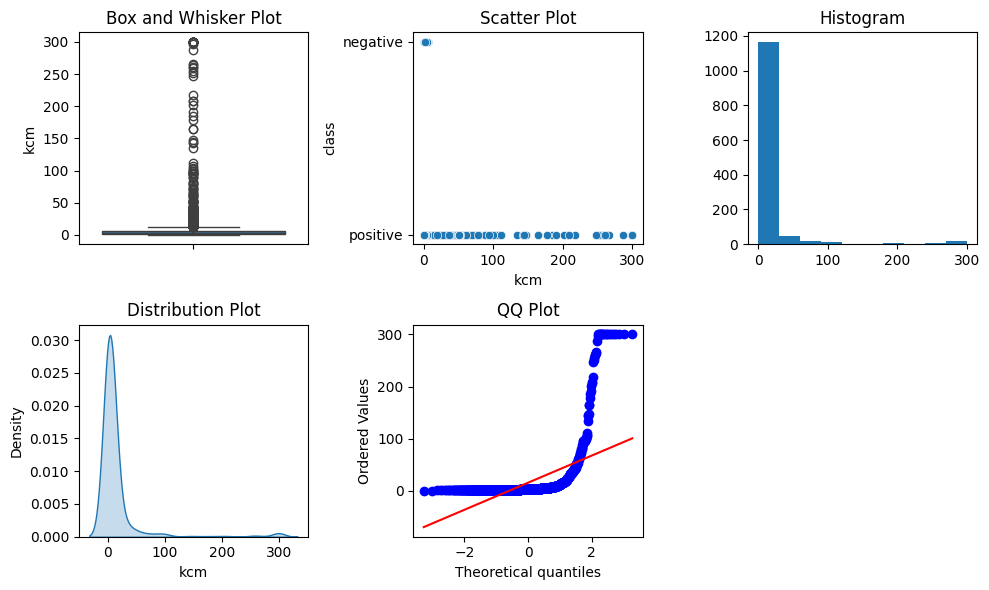

__________________________________________________ 

Hypothesis Testing (Shapiro-Wilk test):
Is the data normally distributed? False
Shapiro-Wilk p-value: 0.0 


kcm description
count    1285.000000
mean       15.367431
std        46.214696
min         0.321000
25%         1.660000
50%         2.870000
75%         5.860000
max       300.000000
Name: kcm, dtype: float64


,kcm
7,300.0
28,300.0
82,300.0
97,300.0
101,165.1
103,300.0
144,264.4
185,300.0
187,286.9
393,300.0


In [29]:
plot_column_visualizations(df_2, 'kcm')
outliers_kcm = detect_outliers(df_2, 'kcm')
print(f'\nkcm description')
print(df_2["kcm"].describe())
outliers_kcm

# Dropping outliers

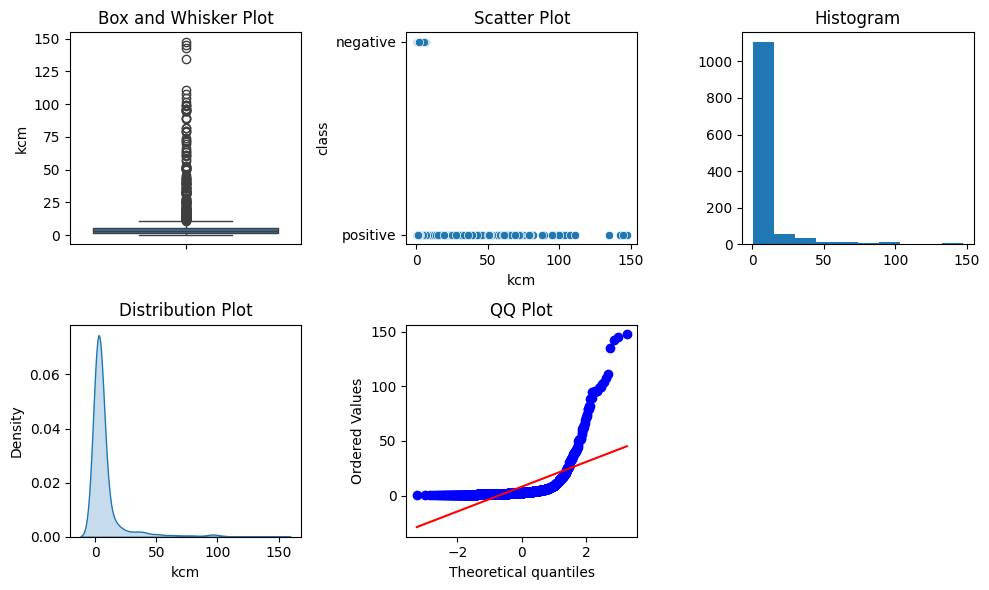

In [30]:

df_2 = remove_outliers(df_2,outliers_kcm)
plot_column_visualizations(df_2, 'kcm')

In [31]:
df_2.shape

(1249, 9)

# Log transformation

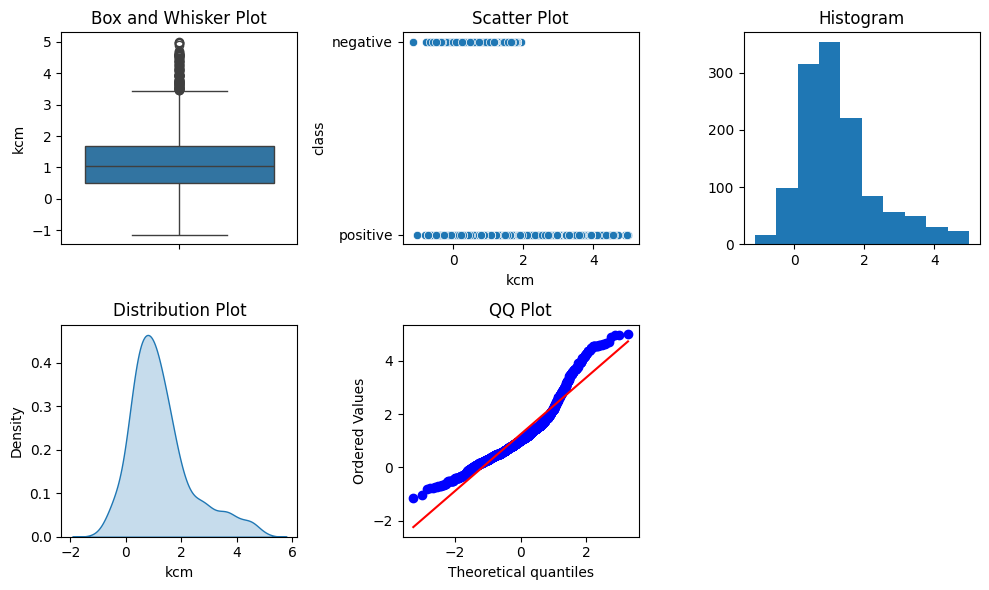


kcm description


count    1249.000000
mean        1.244705
std         1.110858
min        -1.136314
25%         0.494696
50%         1.036737
75%         1.680828
max         4.993150
Name: kcm, dtype: float64

In [32]:
df_2.kcm = log_transform(df_2,'kcm')
plot_column_visualizations(df_2, 'kcm')
print(f'\nkcm description')
df_2["kcm"].describe()

## Troponin

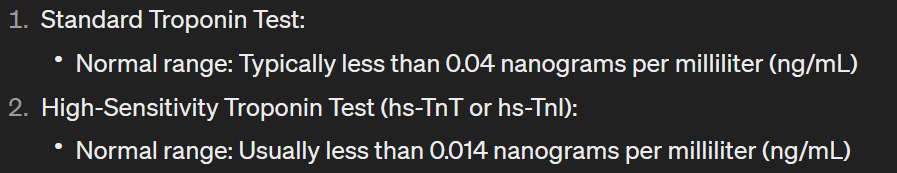

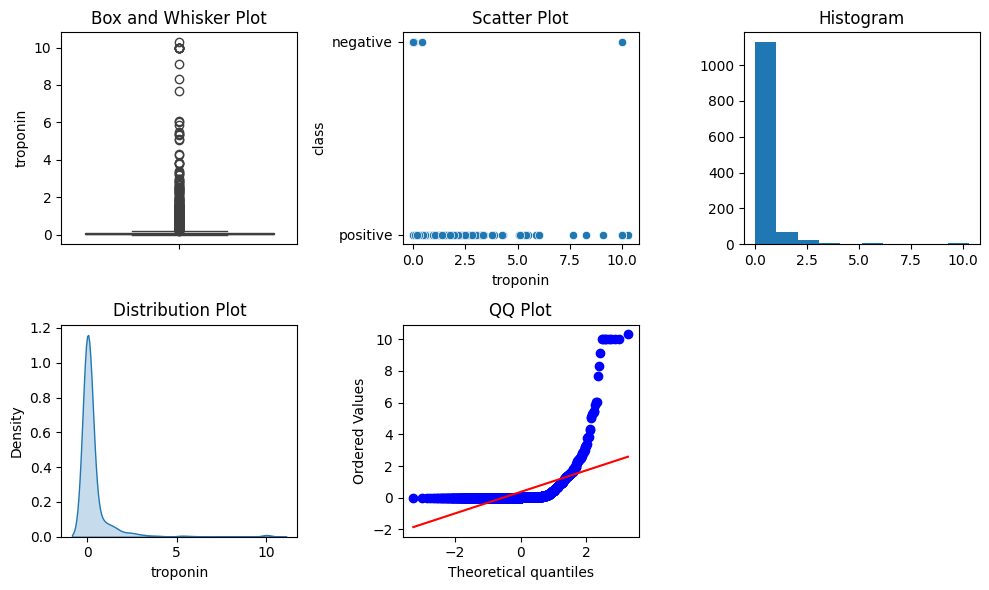

__________________________________________________ 

Hypothesis Testing (Shapiro-Wilk test):
Is the data normally distributed? False
Shapiro-Wilk p-value: 0.0 


troponin description
count    1249.000000
mean        0.368068
std         1.177140
min         0.001000
25%         0.006000
50%         0.014000
75%         0.088000
max        10.300000
Name: troponin, dtype: float64
ntroponin outliers 



,troponin
12,5.37
29,10.00
30,8.30
89,6.05
113,7.67
278,5.05
433,5.31
448,4.32
466,5.48
475,9.11


In [33]:
plot_column_visualizations(df_2, 'troponin')
outliers_troponin = detect_outliers(df_2, 'troponin')
print(f'\ntroponin description')
print(df_2["troponin"].describe())
print("ntroponin outliers \n")
outliers_troponin

# Dropping outliers

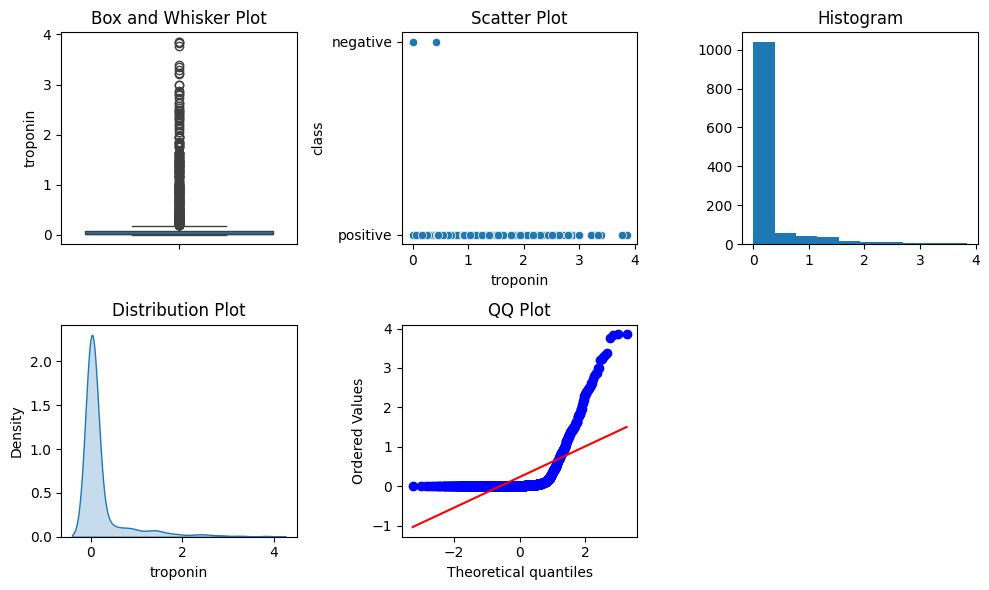

In [34]:
df_2 = remove_outliers(df_2,outliers_troponin)
plot_column_visualizations(df_2, 'troponin')

# Log transformation

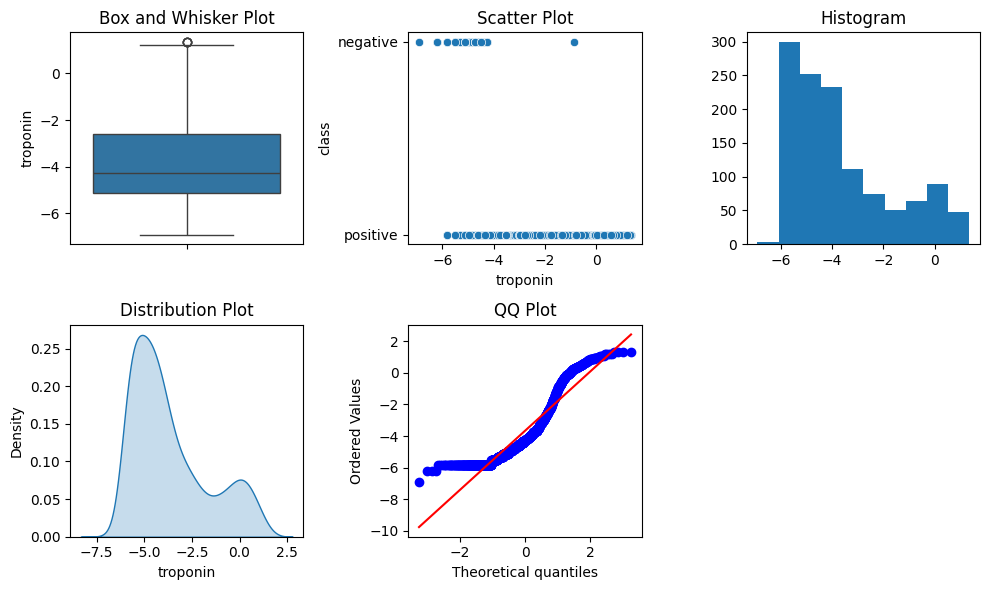


troponin description


count    1226.000000
mean       -3.666796
std         1.991343
min        -6.907755
25%        -5.115996
50%        -4.268698
75%        -2.577022
max         1.348073
Name: troponin, dtype: float64

In [35]:
df_2.troponin =  log_transform(df_2,'troponin')
plot_column_visualizations(df_2, 'troponin')
print(f'\ntroponin description')
df_2["troponin"].describe()

# Show some data

In [36]:
df_2.head(-5)

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,5.075174,0.587787,-4.422849,negative
1,21,1,94,98,46,5.690359,1.909543,0.058269,positive
2,55,1,64,160,77,5.598422,0.688135,-5.809143,negative
3,64,1,70,120,55,5.598422,2.629728,-2.103734,positive
4,55,1,64,112,65,5.703782,0.076961,-5.809143,negative
...,...,...,...,...,...,...,...,...,...
1306,60,0,78,109,69,5.438079,2.968875,-5.809143,positive
1307,56,1,75,157,67,4.644391,0.879627,-0.798508,positive
1308,45,1,117,100,68,5.308268,1.156881,-5.809143,negative
1309,47,1,94,105,81,4.905275,3.590163,-1.335601,positive


# Data distribution after solving skeweness problem

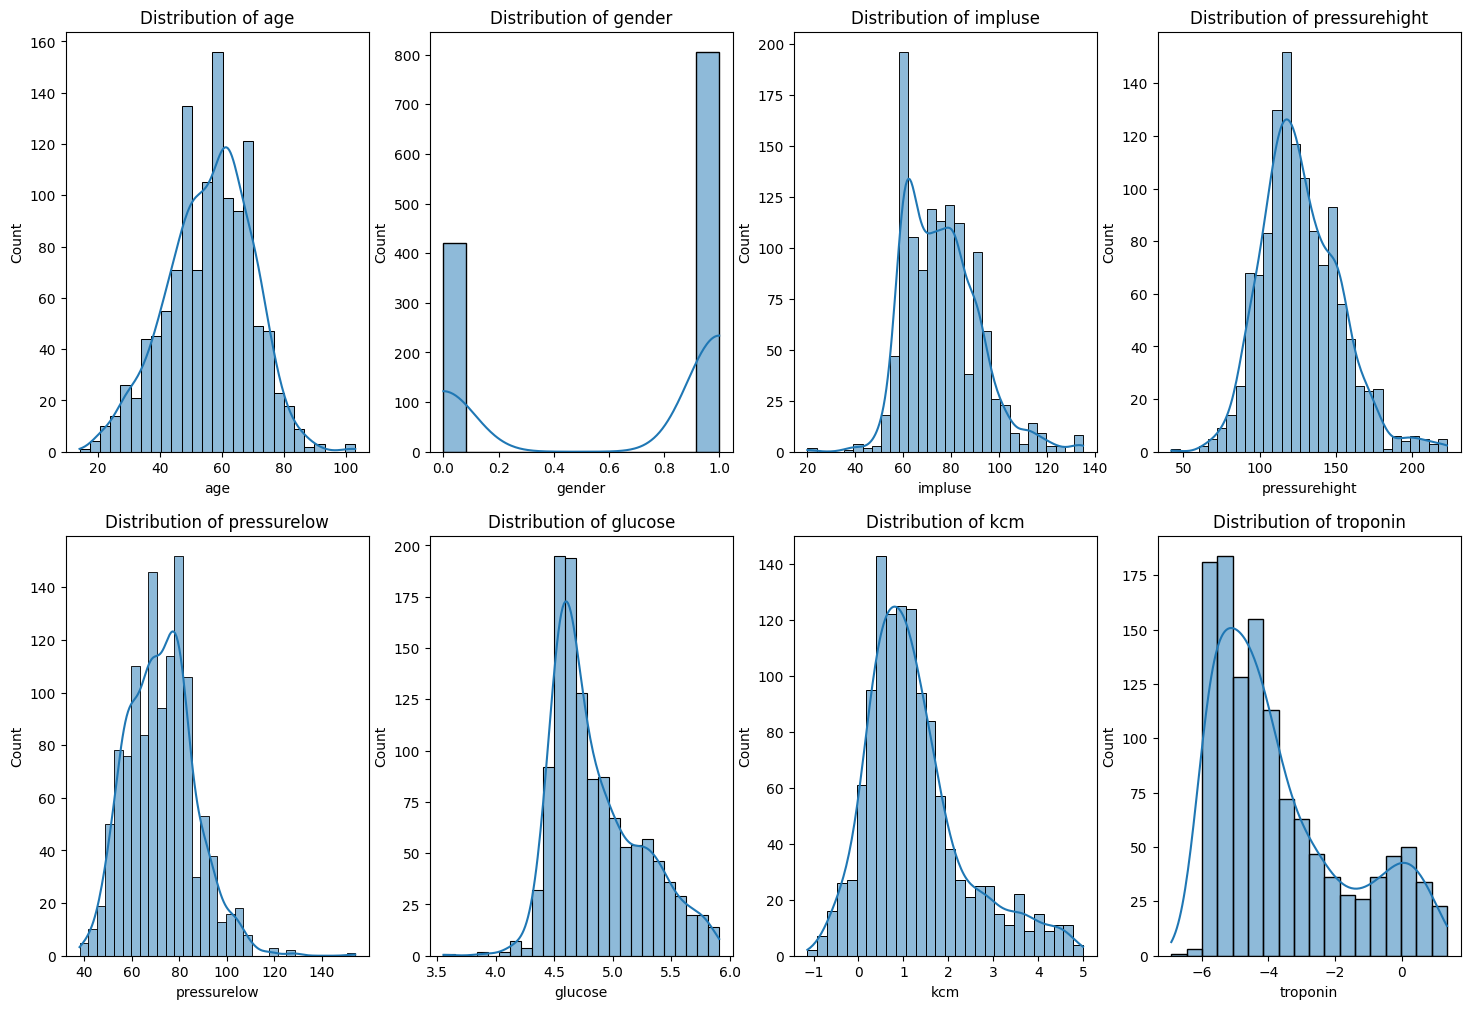

In [37]:
cols = df_2.drop('class',axis=1)
plt.figure(figsize=(18, 12))
for i, column in enumerate(cols.columns):
    plt.subplot(2, 4, i + 1)
    sns.histplot(df_2[column], kde=True)
    plt.title(f'Distribution of {column}')

# Show Skeweness

In [38]:
cols = df_2.drop('class',axis=1)
for column in cols.columns:
    sek = df_2[column].skew()
    if(sek < 0) :
        sek = -sek
    print(f"column  {column} : " , sek)
    if sek == 0:
        print ('Normal')
    elif -0.5 <= sek <= 0.5:
        print('Approximately Symmetric')
    elif sek >= 1 or sek <= 1:
        print('Skewed')


column  age :  0.21511791538081296
Approximately Symmetric
column  gender :  0.6642430211473394
Skewed
column  impluse :  0.7299902679960072
Skewed
column  pressurehight :  0.6220329698562566
Skewed
column  pressurelow :  0.5042649744017597
Skewed
column  glucose :  0.7621942808087092
Skewed
column  kcm :  1.082743369041688
Skewed
column  troponin :  0.9161777467467305
Skewed


# Detect imbalanced classes

In [39]:
class_counts = df_2['class'].value_counts() # we have here two imbalanced classes

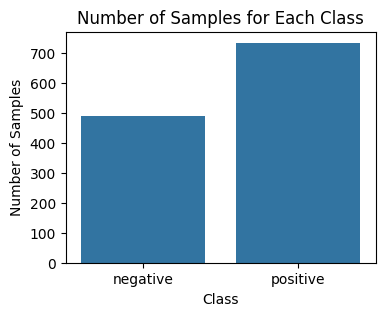

In [40]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df_2['class'], data=df)
plt.title('Number of Samples for Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Encode the target column

In [41]:
df_2.dtypes

age                int64
gender             int64
impluse            int64
pressurehight      int64
pressurelow        int64
glucose          float64
kcm              float64
troponin         float64
class             object
dtype: object

In [42]:
df_2['class'] = target_encode(df_2,'class')

In [43]:
df_2['class'].unique()

array([0, 1])

In [44]:
df_2.dtypes

age                int64
gender             int64
impluse            int64
pressurehight      int64
pressurelow        int64
glucose          float64
kcm              float64
troponin         float64
class              int64
dtype: object

# Solve imbalanced classes

# Downsampling the data

In [45]:
df_pos = df_2[df_2['class'] == 1]
df_neg = df_2[df_2['class'] == 0]

In [46]:
df_pos.shape

(735, 9)

In [47]:
df_neg.shape

(491, 9)

In [48]:
# Downsampling
df_pos_downsampled = resample(df_pos,
                              replace=False,
                              n_samples= 490,
                              random_state = 20)

df_neg_downsampled = resample(df_neg,
                              replace=False,
                              n_samples= 490,
                              random_state = 20)

In [49]:
len(df_pos_downsampled)

490

In [50]:
df_downsampled = pd.concat([df_pos_downsampled, df_neg_downsampled])

In [51]:
df_randomized = df_downsampled.sample(frac=1,random_state=20)
df_randomized

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
959,39,1,103,126,75,5.111988,0.582216,-0.235722,1
405,52,1,96,132,80,5.398163,1.560248,-4.074542,1
590,55,0,64,121,58,4.634729,2.637628,-0.143870,1
513,42,1,94,98,46,4.812184,0.262364,-5.115996,0
281,68,0,57,110,60,5.308268,1.291984,-3.912023,1
...,...,...,...,...,...,...,...,...,...
1100,65,0,60,130,56,5.849325,1.029619,-5.521461,0
376,58,0,69,121,65,4.941642,1.479329,-2.577022,1
825,57,1,82,138,93,5.693732,1.909543,-3.912023,1
434,61,1,74,140,77,4.859812,0.029559,1.172482,1


# Data scale & split

In [52]:
# tsplit features and target
X = df_randomized.drop('class',axis=1)
y = df_randomized['class']

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaling(X_train)
X_test_scaled = scaling(X_test)


In [53]:
df_randomized.head(-5)

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
959,39,1,103,126,75,5.111988,0.582216,-0.235722,1
405,52,1,96,132,80,5.398163,1.560248,-4.074542,1
590,55,0,64,121,58,4.634729,2.637628,-0.143870,1
513,42,1,94,98,46,4.812184,0.262364,-5.115996,0
281,68,0,57,110,60,5.308268,1.291984,-3.912023,1
...,...,...,...,...,...,...,...,...,...
544,56,1,70,113,55,4.653960,-0.320205,-5.809143,0
671,57,1,60,166,90,5.442418,0.788457,-5.809143,0
1116,63,1,61,122,66,4.110874,0.912283,-3.540459,1
263,60,1,100,178,84,4.595120,0.717840,0.165514,1


# Support Vector Machines (SVC)








In [54]:
# Create an instance of the SVC classifier
svm_1 = SVC(kernel='rbf', C= 100, gamma= 0.01)

# Train the classifier
svm_1.fit(X_train_scaled, y_train)

# Make predictions
predictions = svm_1.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)

Accuracy:  0.9081632653061225


# Evaluation

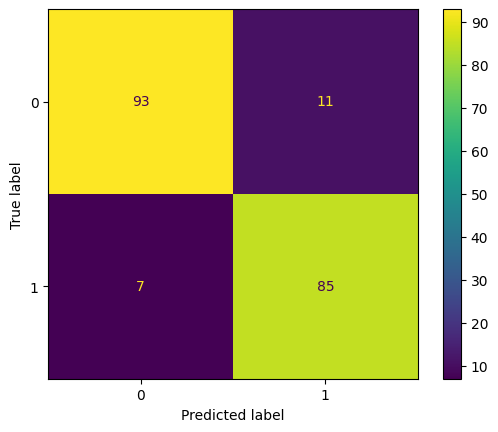

In [55]:
# confsion matrix
conv_mat(y_test,predictions)

# use GridSearchCV for hyperparameter tuning

In [56]:
param_grid = {
    'C': [9,10,12,13],
    'gamma': ['scale', 0.1, 0.2, 0.3, 0.01],
}

# Create the SVM model
svm_2 = SVC(kernel='rbf')

# Perform Grid Search Cross-Validation to find the best parameters
grid_search = GridSearchCV(svm_2, param_grid, cv=10)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found
print("Best parameters: ", grid_search.best_params_)

# Train the model with the best parameters
svm_t = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
svm_t.fit(X_train_scaled, y_train)

# Evaluate the model
svc_score = svm_t.score(X_test_scaled, y_test)
print("Test set score with best parameters: ", svc_score)

Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters:  0.9030612244897959


In [57]:
predictions2 = svm_t.predict(X_test_scaled)

# Evaluation

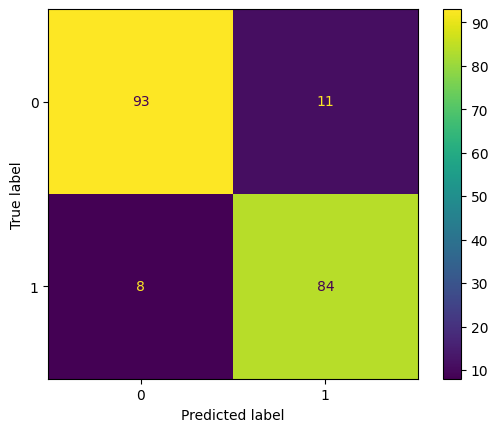

In [58]:
# convusion matrix
conv_mat(y_test,predictions2)

# Decision Tree classifier (DT)




In [59]:
#decision tree
DT_1 = DecisionTreeClassifier()

# Train the model
DT_1.fit(X_train_scaled, y_train)


DecisionTreeClassifier()

In [60]:
# Make predictions on the test set
y_pred = DT_1.predict(X_test_scaled)

In [61]:
# Evaluate the model
classification_rep = classification_report(y_test, y_pred)

In [62]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       104
           1       0.88      0.99      0.93        92

    accuracy                           0.93       196
   macro avg       0.93      0.93      0.93       196
weighted avg       0.94      0.93      0.93       196



In [63]:
accuracy_score(y_test, y_pred)

0.9285714285714286

# Evaluation

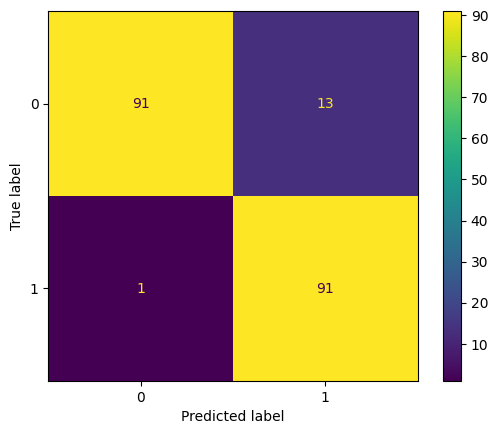

In [64]:
# confsion matrix
conv_mat(y_test,y_pred)

# use GridSearchCV for hyperparameter tuning

In [65]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
DT_2 = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(DT_2, param_grid, cv=5, scoring='accuracy')

# Perform Grid Search to find the best hyperparameters
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
DT_t = grid_search.best_estimator_


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


#  Model predictions with cv

In [66]:
# Evaluate the best estimator on the test set
dt_score = DT_t.score(X_test_scaled, y_test)
print("Accuracy:", dt_score)

Accuracy: 0.9285714285714286


In [67]:
y_pred_cv = DT_t.predict(X_test_scaled)

# Evaluation

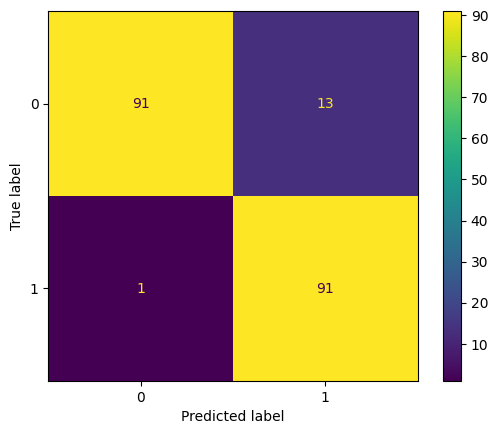

In [68]:
# confsion matrix
conv_mat(y_test,y_pred_cv)

# ANN Model

In [92]:

ann = Sequential([
    Dense(128, activation='ReLU', input_shape=(8,)),
    Dropout(rate=0.5),
    Dense(32, activation='ReLU'),
     Dropout(rate=0.4),
    Dense(1, activation='sigmoid')
])


# Compile the model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [93]:
ann.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 2s 35ms/step - loss: 0.7285 - accuracy: 0.4817 - val_loss: 0.6627 - val_accuracy: 0.6433
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6560 - accuracy: 0.6300 - val_loss: 0.5984 - val_accuracy: 0.7962
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6023 - accuracy: 0.6746 - val_loss: 0.5436 - val_accuracy: 0.8471
Epoch 4/50
10/10 [==============================] - 0s 13ms/step - loss: 0.5564 - accuracy: 0.7368 - val_loss: 0.4916 - val_accuracy: 0.8981
Epoch 5/50
10/10 [==============================] - 0s 9ms/step - loss: 0.5093 - accuracy: 0.7783 - val_loss: 0.4370 - val_accuracy: 0.9172
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.4781 - accuracy: 0.8006 - val_loss: 0.3857 - val_accuracy: 0.9236
Epoch 7/50
10/10 [==============================] - 0s 10ms/step - loss: 0.4447 - accuracy: 0.8182 - val_loss: 0.3408 - val_accuracy: 0.9236
Epoch 8/50
10/

In [94]:
ann.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               1152      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5313 (20.75 KB)
Trainable params: 5313 (20.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
# Evaluate the model on the test set
loss, ann_score = ann.evaluate(X_test_scaled, y_test)
print(f'loss :',loss,'acc : ',ann_score)

7/7 [==============================] - 0s 3ms/step - loss: 0.2720 - accuracy: 0.9286
loss : 0.27199220657348633 acc :  0.9285714030265808


# Convert prob to class

In [96]:
threshold = 0.5
y_pred_ann = ann.predict(X_test_scaled)
y_pred_binary = np.where(y_pred_ann >= threshold, 1, 0)

7/7 [==============================] - 0s 2ms/step


In [98]:
y_pred_ann[0]

array([0.95860714], dtype=float32)

# Evaluation

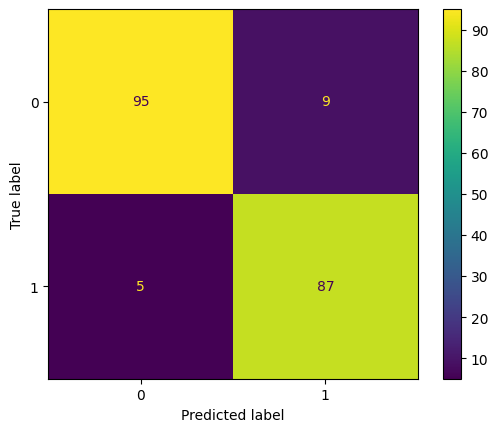

In [99]:
# confsion matrix
conv_mat(y_test,y_pred_binary)

# SVC vs DT vs ANN

In [100]:
result = pd.DataFrame({
    'Algorithms': ['SVC', 'DT', 'ANN'],
    'Test Accuracy' : [svc_score, dt_score, ann_score]
})

result

,Algorithms,Test Accuracy
0,SVC,0.903061
1,DT,0.928571
2,ANN,0.928571


# Models saving

In [102]:
#joblib.dump(svm_model, "model.pkl")

joblib.dump(svm_1, "SVM.pkl")
joblib.dump(svm_t, "SVM_tuned.pkl")
joblib.dump(DT_1, "DT.pkl")
joblib.dump(DT_t, "DT_tuned.pkl")
ann.save("ANN.h5")